In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import scipy.cluster.hierarchy as sch

%matplotlib inline

# feature engineering, selection + preprocessing tools
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import mutual_info_classif, SelectKBest
from sklearn.decomposition import PCA
from feature_engine.outliers import Winsorizer
from feature_engine.encoding import RareLabelEncoder, OrdinalEncoder
from feature_engine.imputation import MeanMedianImputer
from feature_engine.outliers import OutlierTrimmer
from datetime import datetime

# models
import xgboost as xgb
from sklearn.model_selection import  train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.cluster import KMeans, AgglomerativeClustering
from yellowbrick.cluster import KElbowVisualizer

# hyperparameter tuning
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

# metrics
from sklearn import metrics
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.metrics import roc_auc_score

In [2]:
plt.style.use('default')
plt.rcdefaults()
plt.style.use('default')

In [3]:
# function to check missing & duplicated values
def check_data(df):
    print('-' *50)
    
    missing_data = df.isnull().sum().sum()
    
    print(f'There are {missing_data} missing values in the dataset.')
    print(f'There are {df.duplicated().sum().sum()} duplicated values in the dataset.')
    print('-' *50)
    
    if missing_data > 0:
        print('Missing values:')
        print(df.isnull().sum().sort_values(ascending=False))
        print('-' *50)

In [4]:
df = pd.read_csv('dataset/Age_Fossil.csv')
df.head()

,uranium_lead_ratio,carbon_14_ratio,radioactive_decay_series,stratigraphic_layer_depth,geological_period,paleomagnetic_data,inclusion_of_other_fossils,isotopic_composition,surrounding_rock_type,stratigraphic_position,fossil_size,fossil_weight,age
0,0.738061,0.487707,0.907884,91.17,Cretaceous,Normal polarity,False,0.915951,Conglomerate,Middle,50.65,432.00,43523
1,0.560096,0.341738,1.121302,165.44,Cambrian,Normal polarity,False,0.803968,Limestone,Top,48.85,353.29,44112
2,0.424773,0.218493,0.103855,218.98,Cambrian,Normal polarity,True,0.792441,Shale,Bottom,37.66,371.33,43480
3,0.349958,0.704649,0.383617,51.09,Permian,Normal polarity,True,0.074636,Limestone,Bottom,39.10,232.84,30228
4,0.886811,0.777494,0.593254,313.72,Devonian,Normal polarity,True,1.646640,Shale,Top,90.84,277.67,67217


In [5]:
check_data(df)

--------------------------------------------------
There are 0 missing values in the dataset.
There are 0 duplicated values in the dataset.
--------------------------------------------------


In [6]:
num_cols = [var for var in df.columns if df[var].dtype != 'object' ]
num_cols

['uranium_lead_ratio',
 'carbon_14_ratio',
 'radioactive_decay_series',
 'stratigraphic_layer_depth',
 'inclusion_of_other_fossils',
 'isotopic_composition',
 'fossil_size',
 'fossil_weight',
 'age']

In [7]:
# conmvert inclusion_of_other_fossilsto object dtype
df['inclusion_of_other_fossils'] = df['inclusion_of_other_fossils'].astype('object')

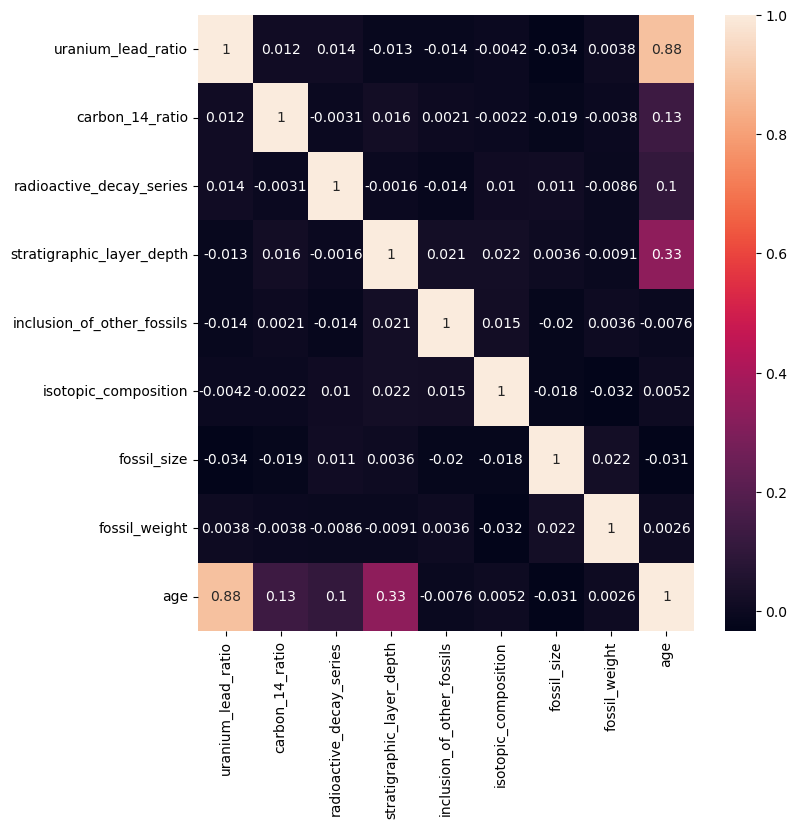

In [8]:
# feature correlation
corr = df[num_cols].corr()

# heatmap
plt.figure(figsize=(8,8))
sns.heatmap(corr, annot=True)
plt.show()

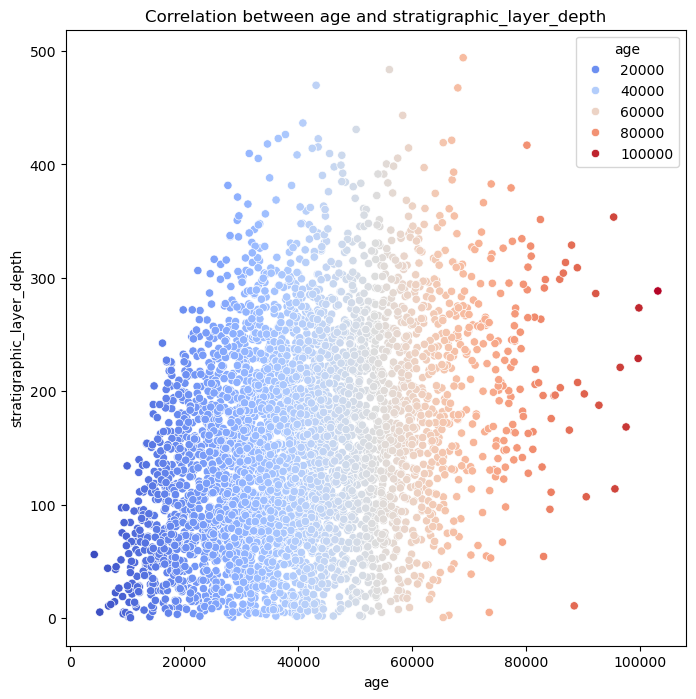

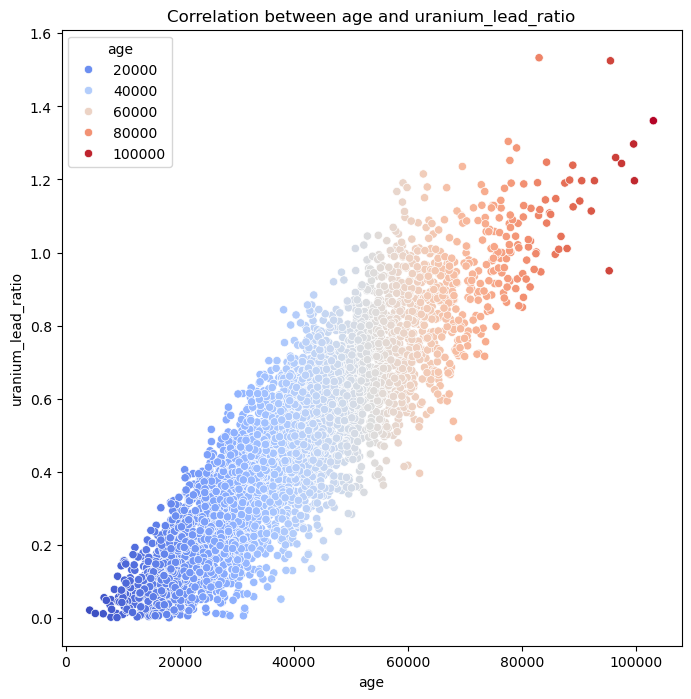

In [9]:
cols = ['stratigraphic_layer_depth', 'uranium_lead_ratio']

for col in cols:
    plt.figure(figsize=(8,8))
    plt.title(f"Correlation between age and {col}")
    sns.scatterplot(data=df, x='age', y=col, hue='age', palette='coolwarm')
    plt.show()

Looking at outliers

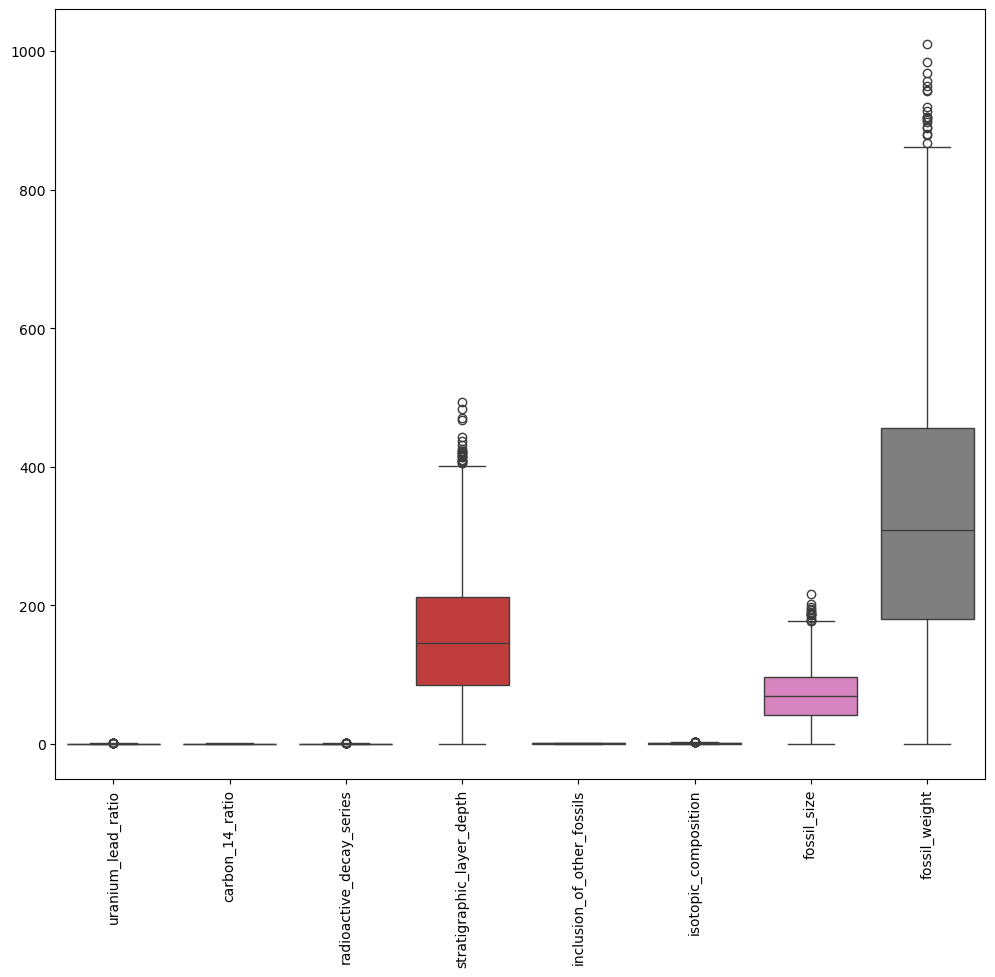

In [10]:
plt.figure(figsize=(12,10))
sns.boxplot(data=df[num_cols].iloc[:,:-1])
plt.xticks(rotation=90)
plt.show()

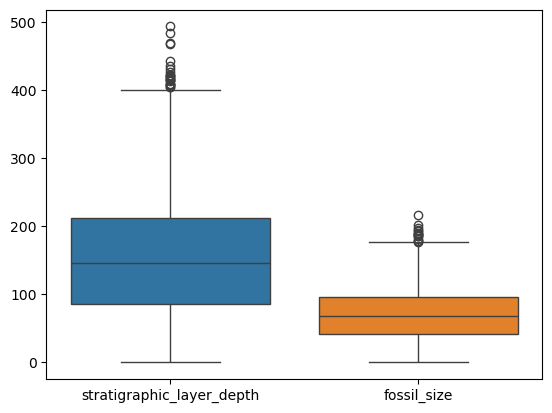

In [11]:
sns.boxplot(df[['stratigraphic_layer_depth', 'fossil_size']])
plt.show()

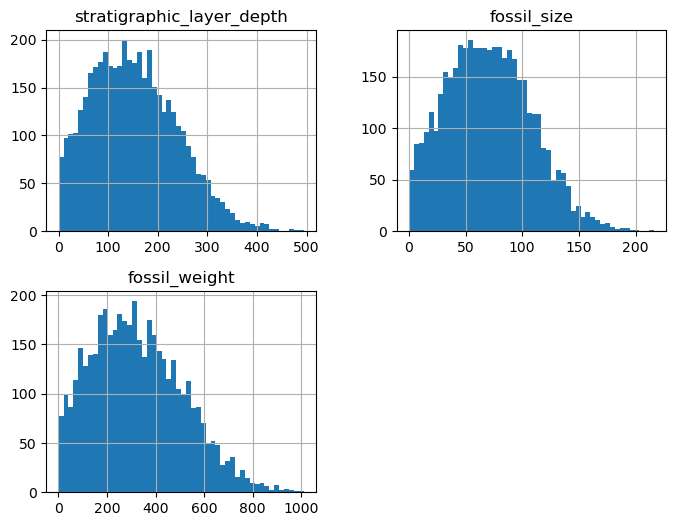

In [12]:
df[['stratigraphic_layer_depth', 'fossil_size', 'fossil_weight']].hist(bins=50,  figsize=(8, 6))
plt.show()

In [13]:
# apply winsorizer for 'stratigraphic_layer_depth' and 'fossil_size'

winsorizer = Winsorizer(
    capping_method='gaussian',
    fold='auto',
    variables= ['stratigraphic_layer_depth', 'fossil_size', 'fossil_weight']
)

df = winsorizer.fit_transform(df)

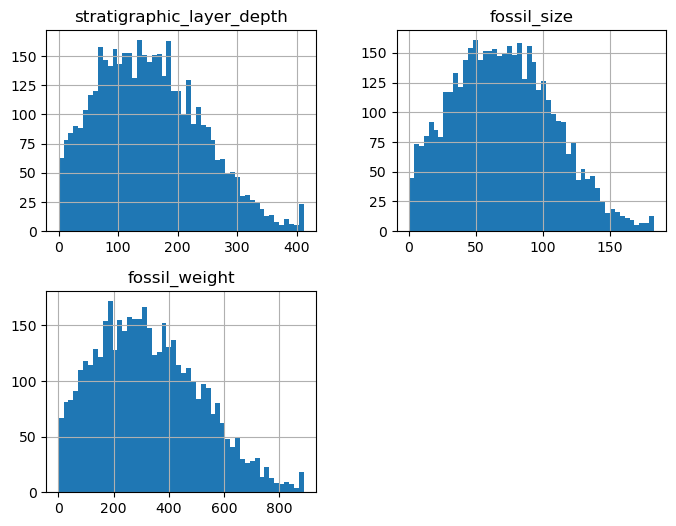

In [14]:
df[['stratigraphic_layer_depth', 'fossil_size', 'fossil_weight']].hist(bins=50,  figsize=(8, 6))
plt.show()

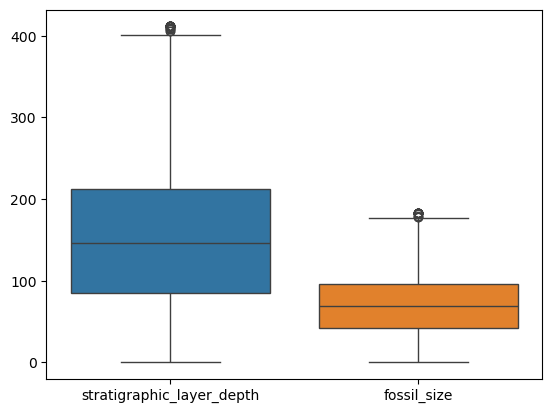

In [15]:
sns.boxplot(df[['stratigraphic_layer_depth', 'fossil_size']])
plt.show()

Training our model

In [16]:
X = df.drop('age', axis=1)
y = df['age']

X.shape, y.shape

((4398, 12), (4398,))

In [17]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.25,
    random_state=0
)

X_train.shape, X_test.shape

((3298, 12), (1100, 12))

Apply Encoding

In [18]:
cat_cols = [var for var in df.columns if df[var].dtype == 'object']
cat_cols

['geological_period',
 'paleomagnetic_data',
 'inclusion_of_other_fossils',
 'surrounding_rock_type',
 'stratigraphic_position']

In [19]:
# Label encoding
cols = ['stratigraphic_position',
        'paleomagnetic_data',
        'surrounding_rock_type',
        'inclusion_of_other_fossils',
        'geological_period']

label_encoder = OrdinalEncoder(
    encoding_method = 'arbitrary',
    variables = ['stratigraphic_position',
        'paleomagnetic_data',
        'surrounding_rock_type',
        'inclusion_of_other_fossils',
        'geological_period']
)


X_train = label_encoder.fit_transform(X_train)
X_test = label_encoder.transform(X_test)

In [20]:
X_train.head()

,uranium_lead_ratio,carbon_14_ratio,radioactive_decay_series,stratigraphic_layer_depth,geological_period,paleomagnetic_data,inclusion_of_other_fossils,isotopic_composition,surrounding_rock_type,stratigraphic_position,fossil_size,fossil_weight
1790,0.230313,0.863420,0.809607,103.51,0,0,0,1.034709,0,0,87.85,444.66
4254,0.441949,0.149967,0.605375,160.71,1,0,1,1.251031,1,0,75.56,229.04
2606,0.723783,0.608809,0.357955,170.47,0,0,0,0.757229,2,1,72.84,347.29
1367,0.752105,0.244392,0.640759,151.34,2,0,1,0.845869,1,2,93.94,342.72
3370,0.897276,0.842674,0.500087,243.47,3,0,1,1.543463,2,2,7.55,68.50


In [21]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((3298, 12), (1100, 12), (3298,), (1100,))

Training our models

In [22]:
models ={
    'Random Forest Regressor': RandomForestRegressor(random_state=0),
    'Decision Tree': DecisionTreeRegressor(random_state=0),
    'XGBoost':  xgb.XGBRegressor(random_state=0)
}

In [23]:
# Training set
result_train = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_train)
    
    mse = mean_squared_error(y_train, y_pred)
    mae = mean_absolute_error(y_train, y_pred)
    r2 = r2_score(y_train, y_pred)
    rmse = np.sqrt(mse)
    
    result_train[name] = {
        'Mean Squared Error': mse,
        'Mean Absolute Error': mae,
        'R^2 Score': r2,
        'Root Mean Squared Error': rmse
    }

In [24]:
comparison_df_train = pd.DataFrame(result_train).T
comparison_df_train.reset_index(inplace=True)
comparison_df_train.rename(columns={'index': 'Model'}, inplace=True)

In [25]:
comparison_df_train

,Model,Mean Squared Error,Mean Absolute Error,R^2 Score,Root Mean Squared Error
0,Random Forest Regressor,947996.630877,748.145995,0.995894,973.651185
1,Decision Tree,0.000000,0.000000,1.000000,0.000000
2,XGBoost,152853.715301,281.052637,0.999338,390.965108


In [26]:
# Test set
result_test = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mse)
    
    result_test[name] = {
        'Mean Squared Error': mse,
        'Mean Absolute Error': mae,
        'R^2 Score': r2,
        'Root Mean Squared Error': rmse
    }

In [27]:
comparison_df_test = pd.DataFrame(result_test).T
comparison_df_test.reset_index(inplace=True)
comparison_df_test.rename(columns={'index': 'Model'}, inplace=True)

In [28]:
comparison_df_test

,Model,Mean Squared Error,Mean Absolute Error,R^2 Score,Root Mean Squared Error
0,Random Forest Regressor,7.066071e+06,2067.739582,0.969453,2658.208298
1,Decision Tree,1.557171e+07,3118.927273,0.932683,3946.100226
2,XGBoost,3.882836e+06,1484.539225,0.983214,1970.491361


- For **MSE**, **RMSE**, and **MAE**, lower values indicate better model performance.
- For **R^2 Score**, the higher the values indicate better model performance.

In [29]:
model_xgb =  xgb.XGBRegressor(random_state=0)
model_rf = RandomForestRegressor(n_estimators=120, random_state=0)
model_dec_tree = DecisionTreeRegressor(random_state=0)

model_xgb.fit(X_train, y_train)
model_rf.fit(X_train, y_train)
model_dec_tree.fit(X_train, y_train)



y_pred_xgb = model_xgb.predict(X_test)
y_pred_rf = model_rf.predict(X_test)
y_pred_dec_tree = model_dec_tree.predict(X_test)

Visualizing Actual vs Predicted Value

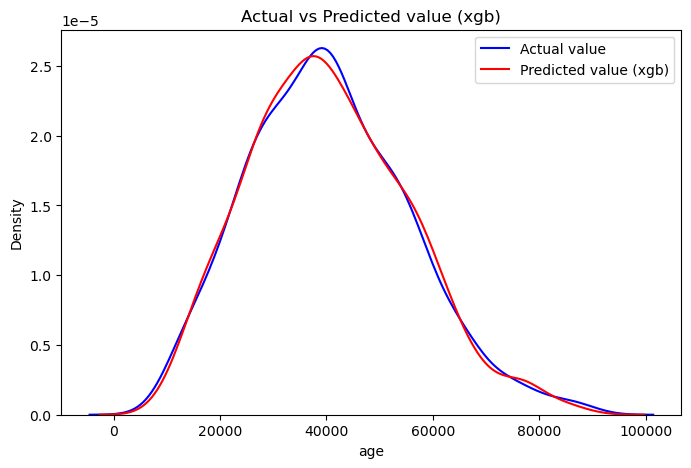

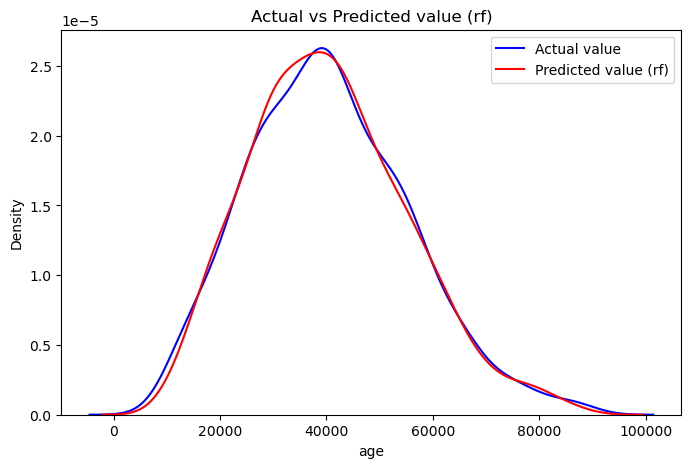

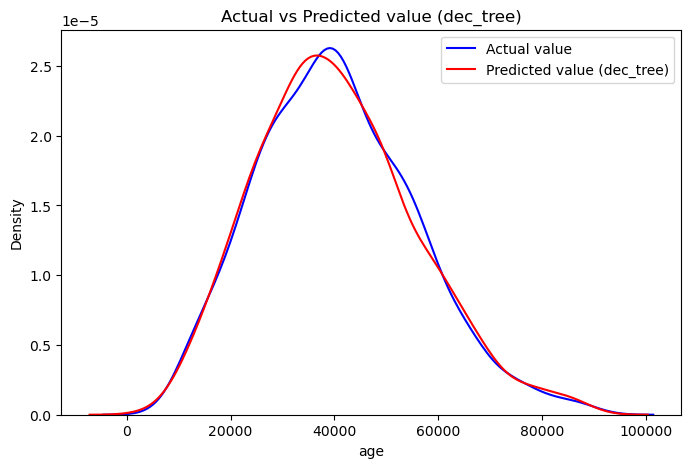

In [30]:
predictions = {
    'xgb': y_pred_xgb,
    'rf': y_pred_rf,
    'dec_tree': y_pred_dec_tree
}


for model_name, y_pred in predictions.items():
    plt.figure(figsize=(8, 5))
    
    sns.kdeplot(y_test, label='Actual value', color='blue')
    sns.kdeplot(y_pred, label=f'Predicted value ({model_name})', color='red')

    plt.title(f"Actual vs Predicted value ({model_name})")
    plt.legend()
    plt.show()

Overall performance: XGBoost Regressor, but since there's issues with the latest update on XGBoost for deployment, we will use RandomForestRegressor for our deployment instead :(.

Testing our model using sample data

In [41]:
df.head(3)

,uranium_lead_ratio,carbon_14_ratio,radioactive_decay_series,stratigraphic_layer_depth,geological_period,paleomagnetic_data,inclusion_of_other_fossils,isotopic_composition,surrounding_rock_type,stratigraphic_position,fossil_size,fossil_weight,age
0,0.738061,0.487707,0.907884,91.17,Cretaceous,Normal polarity,False,0.915951,Conglomerate,Middle,50.65,432.00,43523
1,0.560096,0.341738,1.121302,165.44,Cambrian,Normal polarity,False,0.803968,Limestone,Top,48.85,353.29,44112
2,0.424773,0.218493,0.103855,218.98,Cambrian,Normal polarity,True,0.792441,Shale,Bottom,37.66,371.33,43480


In [39]:
X_train.head(3)

,uranium_lead_ratio,carbon_14_ratio,radioactive_decay_series,stratigraphic_layer_depth,geological_period,paleomagnetic_data,inclusion_of_other_fossils,isotopic_composition,surrounding_rock_type,stratigraphic_position,fossil_size,fossil_weight
1790,0.230313,0.863420,0.809607,103.51,0,0,0,1.034709,0,0,87.85,444.66
4254,0.441949,0.149967,0.605375,160.71,1,0,1,1.251031,1,0,75.56,229.04
2606,0.723783,0.608809,0.357955,170.47,0,0,0,0.757229,2,1,72.84,347.29


In [32]:
y_train

1790    26744
4254    32526
2606    47835
1367    55874
3370    70894
        ...  
1033    39966
3264    35397
1653    34147
2607    38607
2732    42453
Name: age, Length: 3298, dtype: int64

In [33]:
label_encoder.encoder_dict_

{'stratigraphic_position': {'Middle': 0, 'Top': 1, 'Bottom': 2},
 'paleomagnetic_data': {'Normal polarity': 0, 'Reversed polarity': 1},
 'surrounding_rock_type': {'Sandstone': 0,
  'Limestone': 1,
  'Shale': 2,
  'Conglomerate': 3},
 'inclusion_of_other_fossils': {True: 0, False: 1},
 'geological_period': {'Triassic': 0,
  'Ordovician': 1,
  'Jurassic': 2,
  'Neogene': 3,
  'Permian': 4,
  'Cambrian': 5,
  'Devonian': 6,
  'Silurian': 7,
  'Cretaceous': 8,
  'Paleogene': 9,
  'Carboniferous': 10}}

In [34]:
X_train.columns

Index(['uranium_lead_ratio', 'carbon_14_ratio', 'radioactive_decay_series',
       'stratigraphic_layer_depth', 'geological_period', 'paleomagnetic_data',
       'inclusion_of_other_fossils', 'isotopic_composition',
       'surrounding_rock_type', 'stratigraphic_position', 'fossil_size',
       'fossil_weight'],
      dtype='object')

In [35]:
len(X_train.columns), len(df.columns)

(12, 13)

In [36]:
y_train

1790    26744
4254    32526
2606    47835
1367    55874
3370    70894
        ...  
1033    39966
3264    35397
1653    34147
2607    38607
2732    42453
Name: age, Length: 3298, dtype: int64

In [37]:
model_rf.predict(np.array([0.441949, 0.149967, 0.605375, 160.71, 1, 0, 1, 1.251031, 1, 0, 75.56, 229.04]).reshape(1, -1))

c:\Users\ardav\miniconda3\envs\vsc\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


array([33152.05833333])

Save our model for deployment: RandomForestRegressor

In [38]:
import pickle as pkl

with open('.pkl/regressor.pkl', 'wb') as f:
    pkl.dump(model_rf, f)